Found 2949 images belonging to 4 classes.
Found 631 images belonging to 4 classes.
Found 637 images belonging to 4 classes.


C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1711s 34s/step - accuracy: 0.5002 - loss: 1.1480 - val_accuracy: 0.2456 - val_loss: 1.4647 - learning_rate: 1.0000e-04
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 3360s 72s/step - accuracy: 0.7583 - loss: 0.6096 - val_accuracy: 0.2456 - val_loss: 1.5137 - learning_rate: 1.0000e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 972s 21s/step - accuracy: 0.8267 - loss: 0.4837 - val_accuracy: 0.1268 - val_loss: 1.5575 - learning_rate: 1.0000e-04
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1225s 26s/step - accuracy: 0.8361 - loss: 0.4331 - val_accuracy: 0.2900 - val_loss: 1.6349 - learning_rate: 1.0000e-04
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1358s 29s/step - accuracy: 0.8694 - loss: 0.3591 - val_accuracy: 0.3043 - val_loss: 1.5371 - learning_rate: 1.0000e-05
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1218s 26s/step - accuracy: 0.8583 - loss: 0.3733 - val_accuracy: 0.3851 - val_loss: 1.4508 - learning_rate: 1.0000e-05
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 4315s 93s/step - accu

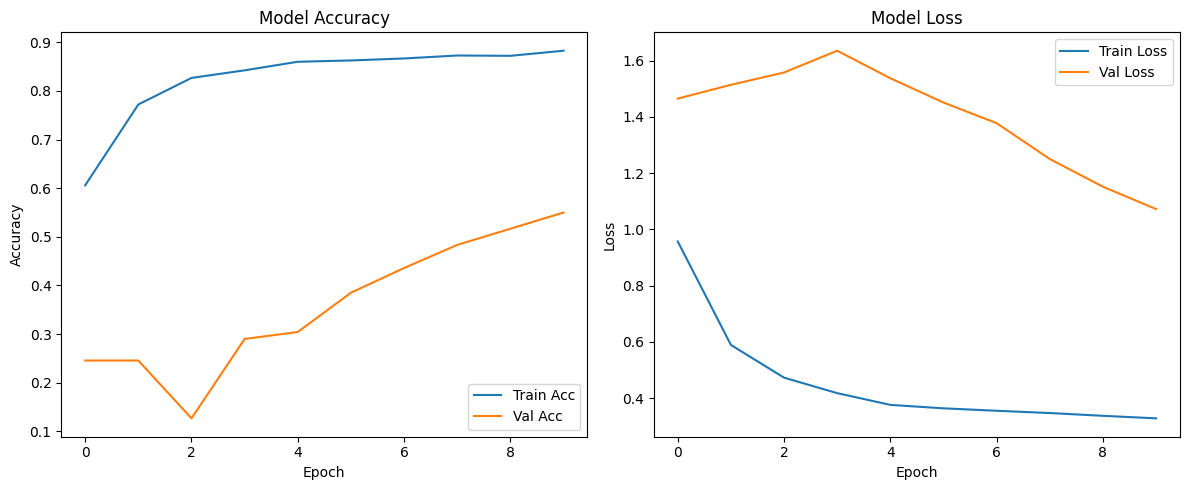

10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step
Classification Report:
                      precision    recall  f1-score   support

            cataract       0.57      0.97      0.72       157
diabetic_retinopathy       0.51      0.90      0.66       166
            glaucoma       1.00      0.04      0.08       152
              normal       0.65      0.28      0.39       162

            accuracy                           0.56       637
           macro avg       0.68      0.55      0.46       637
        weighted avg       0.68      0.56      0.46       637



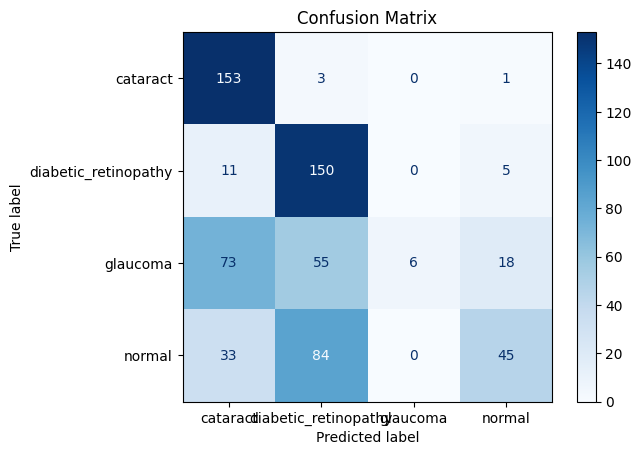

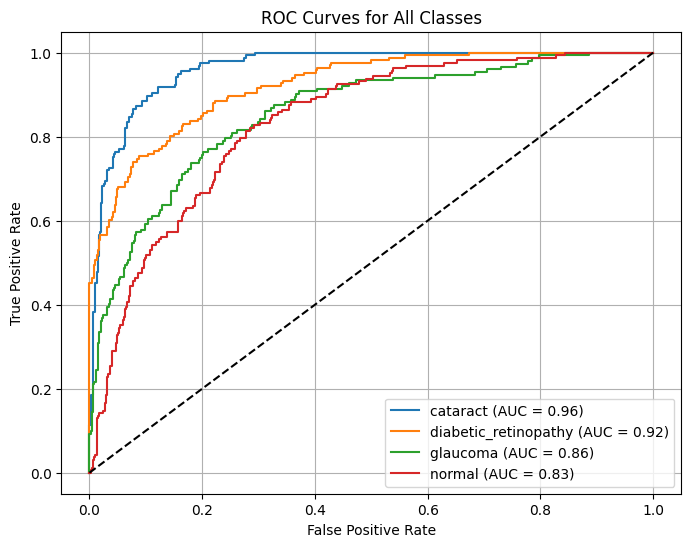

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Paths
base_dir = 'dataset'
train_path = os.path.join(base_dir, 'train')
val_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

# Parameters
batch_size = 64
img_size = (224, 224)
epochs = 10

#  CLAHE Preprocessing
def preprocess_img(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0)
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    final = final.astype(np.float32) / 255.0
    return final

#  Data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_img,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

#  Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

#Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=callbacks
)

#  Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Load best model
model = load_model('best_model.keras')

# Evaluation
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curves
y_true_bin = label_binarize(y_true, classes=list(range(4)))

plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Classes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
